# Better Than Vibes
#### By J. Seaward

While training and fine-tuning models models in a shoestring budget, the question of whether or not we had enough data was a constant problem. Is the problem with the model architecture? the implementation? or do we need more/better data? When I asked how we knew such and such data was enough the answer typically boiled down to "vibes." Let us see if we can do ***better than vibes.***

The goal at the outset was to be able to evaluate a fine-tuning or training set without (re)training the model.
Have not come up with a way to check the sufficiency of a fine-tunin set in the absence of a task *and* model, nor uncovered a unversal scaling law for model parameters and sufficient dataset size. What we have come up with at this point is a way of prioritizing training data at both the sample and set level allowing for automatic pruning of training sets, allowing for cheaper/fast training without loss of performance, as well as ranking of potential fine-tuning sets. These methods rely on the information content of data labels and some simple geometric considerations. In this work, we consider data features as defining a *dataspace* where the data features behave as a basis for a vactorspace in which the samples lie. The label for ever sample then provides some information about it, which we quantify and estimate. To make evaluation of the data model-independant, we construct a self-ignoring distance weighted k-nearest neighbor classifier (explained below), which is applicable well to any dataspace with a meaningful distance metric, or model whose outputs vary smoothly and slowly in data-space.

Marginalia provided in the code blocks.

## Introduction: Information Theory

Shannon information, $I$, is the measure of information a character in a message brings to a receiver. The information a character $a$ brings is written $$I(a) = -\log(p_a),$$ where $p_a$ is the probability that the character $a$ will be received. This probability is conditioned on the previous characters in the message *and* prior knowledge about the type of message. For example, a "u" following a "q" when the message is in English carries almost no information, since "u" nearly always follows "q" (conversely, any other letter carries large amounts of information, narrowing down the rest of the possible characters to only a handful). On the other hand, if the message were encrypted in such a way that all characters were equally likely, "u" after "q" would carry just as much information as any other character, them all having equal probability.

Turning back to machine learning, we can think of each sample in a test set as a message, beginning with the data and ending with the label(s). A model, then, is a machine that guesses the label(s), conditioned on the data *and* what it has seen during training. What we want a model to do is learn the patterns that allow one to infer the next part of a message, given the first part. A language model trained on English text would have learned that "u" nearly allows follows "q", for instance. We can then think of each *label* in a data set as holding a certain amount of information, depending on what the model has already learned. From here, we can start asking questions about how much data is enough and which data sets will be more useful for training.

In [1]:
# Import the module and get a dataset
import btv

# 44156 is the id for the "electricity" datasset, predicting whether the price of electricty rises or falls week to week.
# Feel free to chose another from the openML catalogue (https://www.openml.org/search?type=data&status=active)
# Make sure to update the name of the class column argument if necessary.
df, X, y = btv.data_tabular.dataset2df(44156, class_cols=["class"], verbose=True)

# to reproduce results, uncomment the lines below and use these test/train sets instead of the random ones above
import numpy as np

train_idx = np.load("demo_support/electric_train_set.npy")
test_idx = np.load("demo_support/electric_test_set.npy")
X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# For random split, uncomment below:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

OpenML Dataset
Name..........: electricity
Version.......: 13
Format........: arff
Upload Date...: 2022-07-10 10:34:54
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103281/electricity.arff
OpenML URL....: https://www.openml.org/d/44156
# of features.: 9
# of instances: 38474


### Label information without any data
Without looking at the data or deploying any kind of model, the labels necessarily hold a lot of information. All we have to go on to guess the label of any given data point is the frequency of the label's occurrence. The information in each label, $y_i=c_i$, is written $$I(y_i) = -\log_2[p(y_i=c_i)]$$ where the probability of label $y_i$ being the correct class for the sample, $c_i$, can only be crudely estimated. Note that data of the sample, $x_i$, plays no role and the base of the logarithm makes the unit of information the bit. Call this information given only chance $I^*$, and consider the a prioiri information.

In [2]:
naive_test_info = btv.core.chance_info(y_test, use_freq=False)
frequnecy_test_info = btv.core.chance_info(y_test, use_freq=True)
print(
    "Information in the test set assuming p(label) == 1/# of classes:\n",
    naive_test_info,
)
print(
    "Information in the test set assuming p(label) == 1/# of label ouccurances:\n",
    frequnecy_test_info,
)

Information in the test set assuming p(label) == 1/# of classes:
 7695.0
Information in the test set assuming p(label) == 1/# of label ouccurances:
 7694.651180995905


The frequency-aware information should be *lower* than the one based only on the number of classes, that reflecting the actual distribution of labels better. If they are close, that means the samples are very evenly distributed between the classes.
### Information remaining for a trained model
After training, a model will be able to use the data to infer the label. Therefore the information in the label for a trained model will be much less than using just frequency statistics. It can be written $$I(y_i|x_i;\mathrm{clf}) = -\log_2[p_\mathrm{clf}(y_i=c_i|x_i)],$$ where $p(y_i=c_i|x_i)$ is the probability estimation the classifier, $\mathrm{clf}$, gives to the correct class. A *perfect* model would know every label with certainty from it's data, guess every label correctly with probability one, giving $I=0$ for all samples.

In [3]:
from sklearn.ensemble import GradientBoostingClassifier  # a classic for tabulat data

# feel free to use another classifier. The methods called will be .fit(X,y), .predict_proba(X), and .score(X,y)
clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=10
)
clf.fit(X_train, y_train)
predicted_label_probabilities = clf.predict_proba(X_test)
trained_test_info = btv.core.prediction_info(
    y_test, predicted_label_probabilities
).sum()  # function returns the information of each label
full_train_score = clf.score(X_test, y_test)

print(f"Information in the test set from frqunecy stats: {frequnecy_test_info:.3f}")
print(
    f"Information remaining in test set for trained classifier: {trained_test_info:.3f}"
)
print(f"Score when trained on full training set: : {full_train_score:0.5f}")

Information in the test set from frqunecy stats: 7694.651
Information remaining in test set for trained classifier: 1761.151
Score when trained on full training set: : 0.81092


Since the Shannon information of message can be thought of as the amount of information needed to specify the message, a better-trained model need less information about (or "leave less information in" if you use the thermodynamic analogy of information being hidden in a system) a test set.

In [4]:
import numpy as np

# Select a minimum training set, one that only includes one of every label
min_idx, _ = btv.core.collect_min_set(y_train)
X_min, y_min = X_train[min_idx], y_train[min_idx]
# Fitting to this minimum set will result in a functional, but poor classifier
clf.fit(X_min, y_min)
min_trained_predicted_test_probabilities = clf.predict_proba(X_test)
min_trained_test_info = btv.core.prediction_info(
    y_test, min_trained_predicted_test_probabilities
).sum()
min_trained_score = clf.score(X_test, y_test)

# a training set of almost all zeros will not tell us much about the test set
idx_0s = np.where(y_train == 0)[0]
idx_0splus1 = np.unique(np.append(min_idx, idx_0s))
clf.fit(X_train[idx_0splus1], y_train[idx_0splus1])
almost_all_zero_test_info = btv.core.prediction_info(
    y_test, clf.predict_proba(X_test)
).sum()
zeros_test_score = clf.score(X_test, y_test)

print(f"Information in the test set from frqunecy stats: {frequnecy_test_info:.3f}")
print(
    f"Information remaining in test set for fully-trained classifier: {trained_test_info:.3f}"
)
print(f"Score when trained on full training set: : {full_train_score:0.5f}")
print(
    f"Information remaining in test set for minimum-trained classifier: {min_trained_test_info:.3f}"
)
print(f"Score when trained on minimum training set: : {min_trained_score:0.5f}")
print(
    f"Information remaining in test set for classifier trained on almost all 0 labels: {almost_all_zero_test_info:.3f}"
)
print(f"Score when trained on almost all 0 labels : {zeros_test_score:0.5f}")

Information in the test set from frqunecy stats: 7694.651
Information remaining in test set for fully-trained classifier: 1761.151
Score when trained on full training set: : 0.81092
Information remaining in test set for minimum-trained classifier: 2889.147
Score when trained on minimum training set: : 0.61663
Information remaining in test set for classifier trained on almost all 0 labels: 3561.000
Score when trained on almost all 0 labels : 0.53723


NB: When using a random forest classifier on the electricity data set (OpenML id = 44156), and the train/test split aved in `./demo_support/`, the classifier trained on almost all zeros did *worse* than on trained on only two samples. It left more information in the test set ($\approx$1100 bits) and scored $\approx$8% worse ($\approx$53% accuracy). This is not too surprizing since the training set with only one sample of each labels reflects the class balance of the test set.

This gives us a way to quantify how much information a training set has for a classifier **about** a test set, but only if we are willing to retrain. In that sense it is only another evaluation metric and does not cut out the slow/expensive part of model development. However, when applied to training sets, the more ignorant a classifier is about a set, the more it can potentially learn from it.

#### Looking at the information remaining in the training set after training on subsets of it:

In [12]:
frequnecy_train_info = btv.core.chance_info(y_train)
clf.fit(X_train, y_train)
full_trained_train_info = btv.core.prediction_info(
    y_train, clf.predict_proba(X_train)
).sum()
clf.fit(X_train[: len(y_train) // 10], y_train[: len(y_train) // 10])
tenth_trained_train_info = btv.core.prediction_info(
    y_train, clf.predict_proba(X_train)
).sum()
clf.fit(X_min, y_min)
min_trained_train_info = btv.core.prediction_info(
    y_train, clf.predict_proba(X_train)
).sum()

print(
    f"Information in the training set from frqunecy stats: {frequnecy_train_info:.3f}"
)
print(
    f"Information remaining in train set for minimum-trained classifier: {min_trained_train_info:.3f}"
)
print(
    f"Information remaining in train set for tenth-trained classifier: {tenth_trained_train_info:.3f}"
)
print(
    f"Information remaining in train set for fully-trained classifier: {full_trained_train_info:.3f}"
)

Information in the training set from frqunecy stats: 30778.913
Information remaining in train set for minimum-trained classifier: 11439.607
Information remaining in train set for tenth-trained classifier: 7171.968
Information remaining in train set for fully-trained classifier: 6907.605


The amount of informtion remaining in the entire training set may not be significantly lower when training on all of it vs. training on the whole thing (depending on the clssifier). This hints at the redundancy of training data. In order to find that redundancy, we introduce a modified distance weighted k-nearest neighbor model: the self-drop dknn.

## Estimating Data Redudancy: The Self-Drop d-KNN
A distance weight k-nearest neighbor classifier will take take the weighted average of the classes of the test point's $k$ nearest neighbors to dertimine the probability if its class. The average being weighted by $1/d_i$ where $d_i$ where $d_i$ is the distance to the $i^{th}$ neighbor. This assumes that data points whose features take simillar values (i.e. data points that are *close* in the data-space) are likely to be in the same class. Since this is such a broadly applicable assumption (e.g. metric embedding spaces, data ameanable to clustering, etc.) we take is as a basis for estimating the information a training set has about itself.

A d-knn classifier assigns probabilites to all classes for each point in data space, whether labelled or not. The label on a labelled point provides the classifier with $I(y|x)=0$ because the classifier knows the label there with probability $1$. Likewise, the label on a point near one of the same class (see point highlighted in blue bellow), will provide very little information, since the probability assigned to the correct class is high. Conversely, a point near points of *unlike* class (see point highlighted in red) will provide much more information.

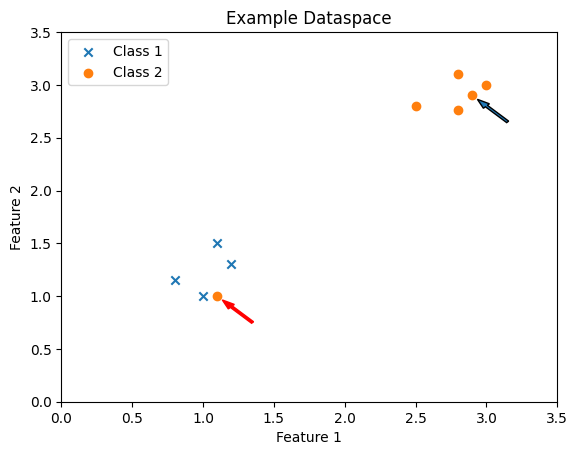

In [13]:
# Example dataspace visualization
from matplotlib import pyplot as plt

c1 = np.array([[1, 1], [1.1, 1.5], [1.2, 1.3], [0.8, 1.15]])
c2 = np.array([[3, 3], [2.8, 3.1], [2.9, 2.9], [1.1, 1], [2.5, 2.8], [2.8, 2.76]])

plt.scatter(c1[:, 0], c1[:, 1], marker="x", label="Class 1")
plt.scatter(c2[:, 0], c2[:, 1], marker="o", label="Class 2")
plt.xlim([0, 3.5])
plt.ylim([0, 3.5])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Example Dataspace")
plt.arrow(1.35, 0.75, -0.15, 0.15, width=0.02, color="r")
plt.arrow(3.15, 2.65, -0.15, 0.15, width=0.02)
plt.legend()
plt.show()

So, a d-knn can estimate how informative a label at a point is given the point's neighbors and thus estimate which labels are most important to keep in a training set and which ones an be discarded. However, a vanilla knn will always return $I(y_i|x_i) = 0$ for all $(x_i,y_i)$ in its training set. That is what "self-drop" adresses. We provide a custom weights function (`fns._src._dist_weight_ignore_self`) which assigns a weight of $0$ to neighbors with $d=0$ instead of letting them determine the outcome of the classifier. This lets us estimate the amount of infrmation a trainig set has about itself.

In [14]:
train_set_self_info = btv.core.estimate_info(X_train, y_train)
clf_knn = btv.core.fit_dknn_toXy(X_train, y_train)
knn_trained_info = btv.core.prediction_info(
    y_train, clf_knn.predict_proba(X_train)
).sum()

print(
    f"Information in the training set from frqunecy stats: {frequnecy_train_info:.3f}"
)
print(
    f"Information remaining in train set for vanilla dknn classifier: {knn_trained_info:.3f}"
)
print(f"Estimated training set self-information: {train_set_self_info:.3f}")
print(
    f"Information remaining in train set for fully-trained classifier: {full_trained_train_info:.3f}"
)

Information in the training set from frqunecy stats: 30778.913
Information remaining in train set for vanilla dknn classifier: 0.000
Estimated training set self-information: 6740.530
Information remaining in train set for fully-trained classifier: 6907.605


We can see that the information estimated by th self-drop knn is close to information remaining in the training set for the RF classifier, 6740 vs. 6907 bits out of 30,778 bits, a difference of $\approx$0.5%.

If this is a good estimation, we can exclude points with low information from the training set and retain performance.

In [ ]:
# Scanning info pruning threshold.
idx_0pruned = btv.selection.prune_by_info(
    X_train, y_train, thresh=0
)  # setting threshold to 0 bits, just to be safe
clf.fit(X_train[idx_0pruned], y_train[idx_0pruned])
pruned_score = clf.score(X_test, y_test)

print(f"Score when trained on full training set: : {full_train_score:0.5f}")
print(
    f"Length of I>0 pruned training set is {len(idx_0pruned)} samples, {len(idx_0pruned)/len(y_train) * 100:0.2f}% of the full training set."
)
print(f"Score when trained on pruned set: : {pruned_score:0.5f}")

scores, lengths, best_threshold = btv.routines.scan_info_thresh(
    X_train, y_train, X_test, y_test, clf, plot=True
)
# plotting routine returns lists of score, dataset lengths, and the threshold that scores the highest.

NB: With the provided data, trained on points with $I>0$ the RF classifier perfomed **better** than when trained on the full set, an accuracy of 0.81442 vs 0.81092.

## Training Set Selection
When chosing a training set, we want to chose one that is as informative as possible. Ideally, it is iformative about the *test* set, but if the training set represents the test set, we can use the self-information about the training set to prioritize the training data, as shown above. However, to compare training sets of different sizes, we need a metric that is insensitive to the size of the set. Rather than use entropy (the average infromation per label), we use the *information rate*, $$r(X,Y;\mathrm{clf}) = \frac{I^*(X,Y) - \sum_iI(y_i|x_i;\mathrm{clf})}{I^*(X,Y)} \qquad \text{for  } x_i \in X, \;y_y \in Y.$$ If $I^*(X,Y)$ is the a priori information in the dataset $(X,Y)$, then the sum gives us the total information left in by the classifier, $\mathrm{clf}$. Dividing by $I^*$ givess us the protion of the information the classifier has learned. This can be thought of in terms of the extraction rate of the model:

In [15]:
full_trained_train_info_rate = btv.core.model_extraction_rate(clf, X_train, y_train)
tenth_trained_train_info_rate = btv.core.model_extraction_rate(
    clf, X_train[: len(y_train) // 10], y_train[: len(y_train) // 10]
)
min_trained_train_info_rate = btv.core.model_extraction_rate(clf, X_min, y_min)

print(
    f"Fraction of information learned from train set by minimum-trained classifier: {min_trained_train_info_rate:.5f}"
)
print(
    f"Fraction of information learned from train set by tenth-trained classifier: {tenth_trained_train_info_rate:.5f}"
)
print(
    f"Fraction of information learned from train set by fully-trained classifier: {full_trained_train_info_rate:.5f}"
)

Fraction of information learned from train set by minimum-trained classifier: 1.00000
Fraction of information learned from train set by tenth-trained classifier: 0.77871
Fraction of information learned from train set by fully-trained classifier: 0.77557


or as an estmiation of the informitaveness of the dataset using a self-drop d-knn:

In [18]:
almost_all_zero_info_rate = btv.core.estimate_rateVSchance(
    X_train[idx_0splus1], y_train[idx_0splus1]
)
pruned_train_info_rate = btv.core.estimate_rateVSchance(
    X_train[idx_0pruned], y_train[idx_0pruned]
)
tenth_train_info_rate = btv.core.estimate_rateVSchance(
    X_train[: len(y_train) // 10], y_train[: len(y_train) // 10]
)
full_train_info_rate = btv.core.estimate_rateVSchance(X_train, y_train)
test_info_rate = btv.core.estimate_rateVSchance(X_test, y_test)


print(
    f"Self-information rate of almost all zeros train set: {almost_all_zero_info_rate:.5f}"
)
print(f"Self-information rate of pruned training set: {pruned_train_info_rate:.5f}")
print(
    f"Self-information rate of first tenth of training set: {tenth_train_info_rate:.5f}"
)
print(f"Self-information rate of the full training set: {full_train_info_rate:.5f}")
print(f"Self-information rate of the test set: {test_info_rate:.5f}")

Self-information rate of almost all zeros train set: 0.91626
Self-information rate of pruned training set: 0.70489
Self-information rate of first tenth of training set: 0.73803
Self-information rate of the full training set: 0.78100
Self-information rate of the test set: 0.75520


NB: Using the saved training sets, the information rate of the pruned dataset is significantly lower than the full training set AND the first tenth of the dataset (0.705 vs. 0.781 vs 0.738). This is not surprrising since the low-information points have been dropped, there is not enough information to correctly reconstruct them from their neighbors. The remaining points are the informative ones for training, including the ones the self-drop d-knn tests at.

If the test set is similar in structue and content to the test set, it's information rate should tell us something about how a classifier trained on it will perform on the test set.

100%|█████████████████████████████████████████████████████████████| 154/154 [02:04<00:00,  1.24it/s]


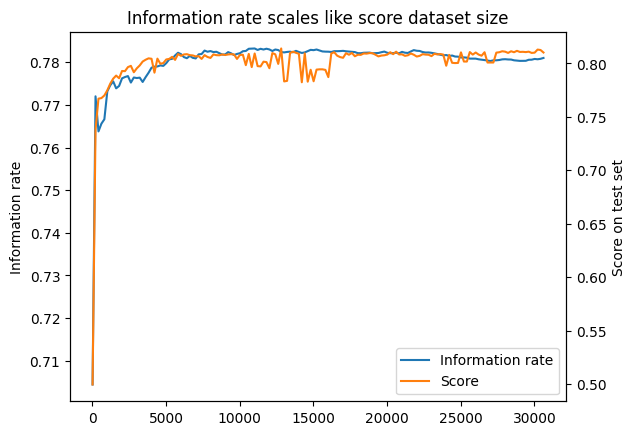

Score when training on full dataset: 0.81092, (30779 training samples)
Score on pruned set: 0.81442, (23480) training samples.
Max score from scanning dataset length: 0.81391, (12814 training samples)


In [11]:
# # How informaation rate scales with dataset size
from tqdm import trange

clf_knn = btv.core.fit_dknn_toXy(X_train, y_train, self_exclude=True)
info_rate = []
scores = []
# set to twice the number of features to cut off very small sets like X_min
start = X_train.shape[1] * 2

for i in trange(start, len(y_train) + 1, 200):
    info_rate.append(btv.core.estimate_rateVSchance(X_train[:i], y_train[:i], clf_knn))
    clf.fit(X_train[:i], y_train[:i])
    scores.append(clf.score(X_test, y_test))

rate_line = plt.plot(
    np.arange(start, len(y_train), 200), info_rate, label="Information rate"
)
ax1 = plt.gca()
ax1.set_ylabel("Information rate")
ax2 = ax1.twinx()
score_line = ax2.plot(
    np.arange(start, len(y_train), 200), scores, color="tab:orange", label="Score"
)
ax2.set_ylabel("Score on test set")
plt.title("Information rate scales like score dataset size")
plt.xlabel("Size of dataset [number of samples]")

lines = rate_line + score_line
lbls = [x.get_label() for x in lines]
plt.legend(lines, lbls)
plt.show()

print(
    f"Score when training on full dataset: {full_train_score:0.5f}, ({len(y_train)} training samples)."
)
print(
    f"Score on pruned set: {pruned_score:0.5f}, ({len(idx_0pruned)} training samples)."
)
print(
    f"Max score from scanning dataset length: {np.max(scores):0.5f}, ({np.argmax(scores)*200+start} training samples)."
)

NB In the provided data sets, the classifier score higher when trained on the information-aware pruned set (0.8144, 23480 training samples) than when selecting the highest score while scanning the length of the whole training set (0.8139, 12814 training samples). This is not true of all splites, however. Rerun `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)` to check. 

If we can use the training set as a stand-in for the test set when estimating what datapoints are most informative, we can prioritize the more informative training data. The routine called in the cells bellow splits the training data into stratified folds, estimates the information rate of each one, takes adds the fold with the highest rate to the training data, refits the provided classifier, then re-enters the loop on the remaining training data. It repeats this loop for until it exhausts the training data or `patience` batches pass without encountering a improvementin score on an internal test set. If no indices are provided for an internal test set, one of the folds is used.

In [19]:
# Can use either a d-kkn:
clf_knn_min = btv.core.fit_dknn_toXy(X_train[:15], y_train[:15], self_exclude=False)
samples, rates, scores, best_idxs = btv.routines.train_best_fold_first_test(
    X_train, y_train, clf_in=clf_knn_min, n_splits=100, patience=15
)
clf.fit(X_train[best_idxs], y_train[best_idxs])
dknn_scanned_score = clf.score(X_test, y_test)
dknn_scanned_len = len(best_idxs)
print(
    f"Score on test set: {dknn_scanned_score}, trained on {dknn_scanned_len} samples."
)

# Or the classifier of interest, if that is cost-effective
clf.fit(X_min, y_min)
samples, rates, scores, best_idxs = btv.routines.train_best_fold_first_test(
    X_train, y_train, clf_in=clf, n_splits=100, patience=15
)
clf.fit(X_train[best_idxs], y_train[best_idxs])
clf_scanned_score = clf.score(X_test, y_test)
clf_scanned_len = len(best_idxs)
print(f"Score on test set: {clf_scanned_score}, trained on {clf_scanned_len} samples.")

 35%|█████████████████████▋                                        | 35/100 [00:21<00:40,  1.59it/s]

No improvement in information rate found after adding 15 folds (4616 samples). Fitting on 20 folds, 6466 smaples.
Best score: 0.749185667752443 on internal test set.


Score on test set: 0.80454840805718, trained on 6466 samples.


 24%|██████████████▉                                               | 24/100 [00:06<00:20,  3.68it/s]

No improvement in information rate found after adding 15 folds (4614 samples). Fitting on 9 folds, 3079 smaples.
Best score: 0.7915309446254072 on internal test set.


Score on test set: 0.8025990903183886, trained on 3079 samples.


The table below is a summary of different training data selection methods with the set length and test set score  we achieved listed. Best values highlighted in bold.

|Selection method | Training set length | Score on test set| Approx time to select [s] |
|:----------------|:-------------------:|:----------------:|:----------------:|
| None            | 30,779              |     0.81092      | 0 |
| Prune 0-info points |  23,480         | **0.81442**      | <1 |
| Scan training set, stop on test score | 12,814 | 0.81391 | 120 |
|Prioritize hi-info training folds ($d$-knn) | 6,466 | 0.80455 | 20 |
|Prioritize hi-info training folds (clf) | **3,079** | 0.80260 |  5 |

## Fine-tuning set selection
Using the information rate proves an effective way to prune training data without losing signifocant performance. Now we consider the case where you have a trained model you wish to fine-tune. To do this, you must have a test set which defines your task, but you may be using a foundational model whose training data you do not have access to. The data selection task is then to chose between different pieces of training data for fine-tuning. When considering a fine-tuning set, we add two cinsiderations: the problem of class imbalanced datasets and geometrical measures of similarity. 

#### Class balance Ratio
Datasets with high class imbalance can have high information rates. The set of >15,0000 samples of one class and one of the other has $r\approx0.916$. 

In [20]:
print("Amost all zeros info rate: ", almost_all_zero_info_rate)

Amost all zeros info rate:  0.9162579366475848


To catch sets like this with strong class difference we can define a *class balance ratio*, which is the ratio of the iformation in the label set when using class frequency statisitics to the information present when using a perfectly flat class distribution. This will be $\le\!1$ since thhe frequency statistics will always provide some information when guessing the labels. In a good training set this will be close to the class ratio of the test set.

In [37]:
print(f"Test set class balance ratio: {btv.core.class_balance_ratio(y_test)}")
print(f"Full train set class balance ratio: {btv.core.class_balance_ratio(y_train)}")
print(f"Minimum train set class balance ratio: {btv.core.class_balance_ratio(y_min)}")
print(
    f"Low-entropy train set class balance ratio: {btv.core.class_balance_ratio(y_train[idx_0splus1])}"
)

Test set class balance ratio: 0.9999546693951793
Full train set class balance ratio: 0.9999971666809189
Minimum train set class balance ratio: 1.0
Low-entropy train set class balance ratio: 0.000995736785206791


Calculating the class balance ratio also provides a good check for when a subset has not been shuffled properly.

In [36]:
print(
    f"Class balance ratio for first 1,000 samples in original set: {btv.core.class_balance_ratio(y[:1000])}"
)
print("All 1,000 labels are the same: ", all([label == y[0] for label in y[:1000]]))

Class balance ratio for first 1,000 samples in original set: nan
All 1,000 labels are the smae:  True


Now we have a way to elimate datasets whose class balance differs strongly from the test set. 

#### Geometric similarity measures
When fine-tuning a model, it is useful to have fine-tuning data the is different from the data the model was originally trained on and simmilar to the test data defining the task. In this package we estimate difference and similatiry using the *overflow* and *overlap* of the convex hulls of the datasets. We use convex hulls because they are computationaly tractable in high dimension in a way that precise volumetric integrations are not. Otherwise, we would be comparing information densities at different locations.

The overflow of set $X_1$ from $X_2$ is the volume of data in $X_1$ outside the hull of $X_2$, given by $$ OF(X_1,X_2) = V(\mathrm{Conv}(X_1\cup X_2)) -   V(\mathrm{Conv}(X_2)),$$ where $\mathrm{Conv}(\cdot)$ gives the convex hull of a set of points and $V(\cdot)$ gives the volume of a shape. Since overlap uses the covex hull this can be thrown off by outliers. Normalizing by $V(\mathrm{Conv}(X_1))$ can help with this since it estimates the protion of $X_1$ outside of $X_2$ which may be more interpretable and will be less sensitive to a few outliers. 

The overlap of $X_1$ with $X_2$ is the volume of $\mathrm{Conv}(X_1)$ inside of $\mathrm{Conv}(X_2)$ and is simply $$OL(X_1,X_2) = V(\mathrm{Conv}(X_1)) - OF(X_1,X_2).$$

Functions for these quantities are `btv.selection.estimate_overflow` and `btv.selection.estimate_overlap`

In the context of dataset selection, a good fine-tuning set should have a large overlap with the test set (for obvious reasons) and a large overflow from the training data, indicating it is now to the model. Without access to the orginal training data, one can use the information given by the trained classifier; data in has seem before will have litte information for it.

## The selection routine
The function called bellow, `btv.selection.select_ft_sets` takes in ordered list of fine-tuning set and selects, scores, and ranks them on different metrics

btv.selection.fuzzy_argrank` does anything for you. It allows a tolerance between scores to count as a tie and them passes those elements back in an unchanged block where the block is ranked by its average.

In [5]:
# Chosing between fine-tuning sets, the X/y_dev* sets.
from sklearn.model_selection import train_test_split

# Uncomment all this suff bellow to start fresh

# ds = data_tab.getdata(44156, verbose=False)
# df, X, y = data_tab.dataset2df(ds, class_cols=["class"])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# clf = GradientBoostingClassifier(
#     n_estimators=100, learning_rate=1.0, max_depth=1, random_state=10
# )
# clf.fit(X_train, y_train)
# print(clf.score(X_test, y_test))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_dev1, y_train, y_dev1 = train_test_split(X_train, y_train, test_size=0.2)
X_train, X_dev2, y_train, y_dev2 = train_test_split(X_train, y_train, test_size=0.2)
X_train, X_dev3, y_train, y_dev3 = train_test_split(X_train, y_train, test_size=0.2)
X_train, X_dev4, y_train, y_dev4 = train_test_split(X_train, y_train, test_size=0.2)
X_train, X_dev5, y_train, y_dev5 = train_test_split(X_train, y_train, test_size=0.2)

X_ft_list = [X_dev1, X_dev2, X_dev3, X_dev4, X_dev5]
y_ft_list = [y_dev1, y_dev2, y_dev3, y_dev4, y_dev5]

X_ft_list, y_ft_list, sort_idx = btv.selection.select_ft_sets(
    X_ft_list, y_ft_list, X_test, y_test, X_train
)

clf.fit(X_train, y_train)  # fit on new, smaller train
print("New all-train score:", clf.score(X_train, y_train))
for i, (X_ft, y_ft) in enumerate(zip(X_ft_list, y_ft_list)):
    new_x = np.vstack([X_train, X_ft])
    new_y = np.append(y_train, y_ft)
    clf.fit(new_x, new_y)
    print(f"Score for ft set ranked {i+1}: {clf.score(X_test,y_test):0.5f}")

Test set class balance ratio is 0.99995.
Information of test set estimated at 1883.62049.
Information rate of test set estimated at 0.75520.
Fine-tune sets must have an information rate of 0.73255 for inclusion.


Estimating class balance ratio for fine tuning sets..: 100%|████████| 5/5 [00:00<00:00, 1303.47it/s]
Checking overlap with test set...: 100%|██████████████████████████████| 5/5 [00:50<00:00, 10.02s/it]


INFO: Dropping fine tuning set at index 4. Estimate that it overlaps with -0.041% of the test set.


Estimating portion outside the training set...: 5it [00:48,  9.64s/it]


+------------------------------------------+
|             train_overflows              |
+-------------+------+---------------------+
| Input index | Rank |        Value        |
+-------------+------+---------------------+
|      0      |  4   | 0.30710233946112286 |
|      1      |  2   |  0.4644187760492607 |
|      2      |  1   |  0.6729803409754808 |
|      3      |  3   | 0.33515403333026256 |
|      4      |  5   |         0.0         |
+-------------+------+---------------------+
+-----------------------------------------+
|                info_rates               |
+-------------+------+--------------------+
| Input index | Rank |       Value        |
+-------------+------+--------------------+
|      0      |  2   | 0.7494890645570793 |
|      1      |  1   | 0.7525532777236144 |
|      2      |  3   | 0.7440964052912885 |
|      3      |  5   | 0.7423368356046793 |
|      4      |  4   | 0.7425590443282877 |
+-------------+------+--------------------+
+--------------------

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 10084 and the array at index 1 has size 6156

## That's it!
Have a play around with the functions provided. Try different datasets, model and splits. Dig through the code in `_src` to see what I was trying and thinking about. Try out some the other selection methods in `btv.selection`. See if `btv.selection.fuzzy_argrank` does anything for you. `btv.routines`has a few things I found useful durinf development.

I am interested in extending this analysis to image data and to see what it could do on semantic metric spaces, such as word2vec or clip embeddings.